Imports and declarations
========================

In [1]:
import pandas as pd;
import opTools.opUtils.io_utils as opio;

import opTools.data_re_format as data_reformation

def log_df(df, title):
    s = f"*  {title}\n   {len(title) * "="}"
    print(f"\n{s}:\n   columns:{df.shape[1]} x rows:{df.shape[0]}");
    

In [2]:
CONFIG = opio.load_configuration("quick.conf.yml");
print(f"Configuration: v{CONFIG["version"]}\n\n{CONFIG["info"]}");

Configuration: v0.1

The multiparameter, per-segment 
power consumption forecast
algorithm



Split data by segment change
============================

In [3]:
df = opio.df_from_csv(**CONFIG["data_source"]);
log_df(df, "Load raw data from file");

df_source = data_reformation.execute(df, **CONFIG["data_re_format"])
log_df(df_source, "reformat to data source")



*  Load raw data from file
   =======================:
   columns:50 x rows:67223

*  reformat to data source
   =======================:
   columns:11 x rows:27000


In [4]:
import opTools.data_segmentation as seg
dfs_list, dfs_grouped = seg.execute(df_source, **CONFIG["data_preprocessing"]);

In [5]:
import opTools.build_per_segment_statistics as proc
df_segments_route, df_segments_dictionary = proc.execute((dfs_list, dfs_grouped), **CONFIG["build_per_segment_statistics"]) 

In [6]:
log_df(df_segments_route, "train route in segments");
log_df(df_segments_dictionary, "averaged segments statistics dictonary");


*  train route in segments
   =======================:
   columns:8 x rows:704

*  averaged segments statistics dictonary
   ======================================:
   columns:7 x rows:26


Neural Network Building
=======================

In [7]:
import numpy as np;
df = df_segments_route;

df_raw = data_reformation.execute(df, **CONFIG["segments_route_re_format"])
df_raw.index = np.arange(df_raw.shape[0]);
df_raw.dropna(axis=0);

In [8]:
LEARN_COUNT = 300;
PREDICT_COUNT = 38;
INPUT_NEURONS_COUNT = 12;
HIDDEN_NEURONS_COUNT = 13;

EPOCHS_COUNT = 50
COUNT_BATCH_SIZE = 15;

all_columns = CONFIG["segments_route_re_format"]['processing_columns'];
STATIC_PARAMETERS = ['Segment','Samples count','Duration','Voltage delta']
predicted_parameters = ['Start segment voltage'];


In [9]:
from opTools.opUtils.data_preprocessing import normalize_data, re_normalize_data;
df_raw = df_raw.loc[0:LEARN_COUNT + PREDICT_COUNT + INPUT_NEURONS_COUNT - 1 ,:]

df1, min_max = normalize_data(df_raw);
df1.shape

(350, 5)

In [10]:
from UTILS.anns_utils_py import df_to_shifted_tables, build_multiparamiters_model,predict_time_window_with_knowns;
x_train, y_train, x_test, y_test = df_to_shifted_tables(df1, INPUT_NEURONS_COUNT, LEARN_COUNT)

2024-03-31 17:57:04.619439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


In [11]:
(y_train.shape, y_test.shape, y_test.columns)

((300, 5),
 (38, 5),
 Index(['Segment', 'Samples count', 'Duration', 'Voltage delta',
        'Start segment voltage'],
       dtype='object'))

In [12]:
model = build_multiparamiters_model(all_columns, predicted_parameters, INPUT_NEURONS_COUNT, hiden_layer_neurons = HIDDEN_NEURONS_COUNT)

Neural Network Training
=======================

In [13]:
import time
start = time.time()
epochs_hist = model.fit(x_train, y_train[predicted_parameters], epochs = EPOCHS_COUNT, batch_size = COUNT_BATCH_SIZE)
end = time.time()
print(start,'... ',end, '=>', (end-start))

model.summary()

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4916 - mean_absolute_error: 1.1491
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1531 - mean_absolute_error: 0.3097
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0914 - mean_absolute_error: 0.2481
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0623 - mean_absolute_error: 0.2036
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0457 - mean_absolute_error: 0.1742
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0361 - mean_absolute_error: 0.1516
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0307 - mean_absolute_error: 0.1375
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0265 - mean_absolute_error: 0.1312
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0199 - mean_absolute_error: 0.1126
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0202 - mean_absolute_error: 0.1097
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Inp_Segment         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Samples_count   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Duration        │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Voltage_delta   │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Inp_Start_segment_… │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 60)        │          0 │ Inp_Segment[0][0… │
│ (Concatenate)       │                   │            │ Inp_Samples_coun… │
│                     │                   │            │ Inp_Duration[0][… │
│                     │                   │            │ Inp_Voltage_delt… │
│                     │                   │            │ Inp_Start_segmen… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_Start_segment_… │ (None, 13)        │        793 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_Start_segment_… │ (None, 1)         │         14 │ mid_Start_segmen… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,423 (9.47 KB)

 Trainable params: 807 (3.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,616 (6.32 KB)

In [14]:
# assessment of the quality of the model on the test set
scores = model.evaluate(x_test, y_test[predicted_parameters])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0411 


Forecasts:
==========

- Test ANN
  --------

In [15]:
ann_test = model.predict(x_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


- Forecast with the time-windows method
  -------------------------------------

In [16]:
# predict with the time-windows method
df_knowns = y_test.loc[LEARN_COUNT:LEARN_COUNT+PREDICT_COUNT+INPUT_NEURONS_COUNT, STATIC_PARAMETERS];

# df_knowns = y_test
ptw = predict_time_window_with_knowns(y_train, model, predicted_parameters, df_knowns)


(300, 5)
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/Users/ozabolotnyy/myProjects/OLENA/plPolitech/PyANN/Archive_2/UTILS/anns_utils_py.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat([df_predictions, df_predicted]);


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


 - Forecast static ann-inputs via the Stationary process modeling method
   ---------------------------------------------------------------------

In [19]:
route_in_sectors = df_raw.Segment[-PREDICT_COUNT:]

df_segments_dictionary.index = df_segments_dictionary.Segment
stationaty_means_forecasts = df_segments_dictionary.loc[route_in_sectors,STATIC_PARAMETERS]
stationaty_means_forecasts.index = route_in_sectors.index

stationaty_means_normalized, _ = re_normalize_data(stationaty_means_forecasts, min_max)
# stationaty_means_normalized[["Voltage delta", "Duration"]].plot()



In [20]:
voltage_0 = y_train.iloc[-1, :][ predicted_parameters].values[0]
stationary_forecast = [voltage_0 := voltage_0 - x for x in stationaty_means_normalized["Voltage delta"] ]
len(stationary_forecast)

38

- Time-Window Forecast with the modeled static parameters as the stationary processes
  -----------------------------------------------------------------------------------

In [21]:
ptw_real = predict_time_window_with_knowns(y_train, model, predicted_parameters, stationaty_means_normalized)


(300, 5)
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


/Users/ozabolotnyy/myProjects/OLENA/plPolitech/PyANN/Archive_2/UTILS/anns_utils_py.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_predictions = pd.concat([df_predictions, df_predicted]);


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 -- Segment
 -- Samples count
 -- Duration
 -- Voltage delta
 -- Start segment voltage


In [22]:
df_preds = y_test.loc[:, predicted_parameters]
df_preds["model_test"] = ann_test
df_preds["pwd-predicted"] = ptw
df_preds["pwd-predicted-real"] = ptw_real


Forecasts results report
========================

<Axes: >

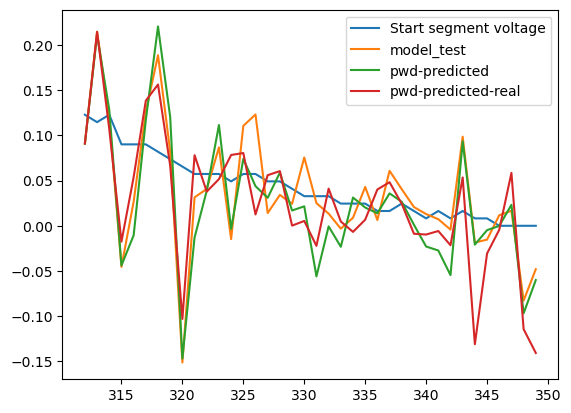

In [23]:
df_preds.plot()
